In [74]:
from dotenv import load_dotenv
import os
import getpass

load_dotenv()

True

In [75]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [76]:
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"

In [77]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="moonshotai/kimi-k2-instruct"
)

In [78]:
result=llm.invoke('What is two sum problem? Explain in 50 word or less.')

In [79]:
result.content

'Given an array and a target, find two numbers whose sum equals the target; return their indices.'

The Two Sum problem asks you to find two numbers in a given array of integers that sum up to a specific target number. You typically return the indices of these two numbers. It's a classic problem, often solved efficiently using a hash map.

In [80]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

In [81]:
python_repl = PythonREPL()

In [82]:
python_repl.run("print(1+1)")

'2\n'

In [83]:
python_repl.run("""
def fib(n):
    if n <= 1:
        return n
    return fib(n-1) + fib(n-2)

fib(10)
""")


'NameError("name \'fib\' is not defined")'

In [84]:
from langchain_experimental.utilities import PythonREPL
import sys
from io import StringIO

class PersistentPythonREPLTool(PythonREPL):
    def __init__(self):
        super().__init__()
        self._globals = {}

    def run(self, command: str) -> str:
        # Capture stdout
        old_stdout = sys.stdout
        sys.stdout = captured_output = StringIO()
        
        try:
            # First try eval (single expression)
            result = eval(command, self._globals)
            output = captured_output.getvalue()
            if output:
                return output + str(result)
            return str(result)
        except SyntaxError:
            # If it's a statement block, use exec
            try:
                exec(command, self._globals)
                output = captured_output.getvalue()
                return output if output else "Executed successfully with no output."
            except Exception as e:
                output = captured_output.getvalue()
                return output + repr(e) if output else repr(e)
        except Exception as e:
            output = captured_output.getvalue()
            return output + repr(e) if output else repr(e)
        finally:
            # Restore stdout
            sys.stdout = old_stdout

In [85]:
# Create a new instance with the fixed version
python_repl = PersistentPythonREPLTool()

# Test the fixed tool with print statements
print("Testing fixed REPL tool:")
print(python_repl.run("""
def twoSum(nums, target):
    print("Running Two Sum function...")
    num_map = {}
    for i, num in enumerate(nums):
        complement = target - num
        if complement in num_map:
            return [num_map[complement], i]
        num_map[num] = i
    return []

print("Function defined successfully!")
result = twoSum([2, 7, 11, 15], 9)
print(f"Result: {result}")
"""))


Testing fixed REPL tool:
Function defined successfully!
Running Two Sum function...
Result: [0, 1]



In [86]:
# You can create the tool to pass to an agent with the fixed python_repl
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be" \
                " a valid python command. If you want to see the output of a value, you " \
                "should print it out with `print(...)`.",
    func=python_repl.run,
)

In [87]:
llm_with_tools=llm.bind_tools([repl_tool])

In [88]:
result=llm_with_tools.invoke("What is two sum problem? Explain in 50 word or less. and run the code with the tool to show me some test cases")

In [89]:
result

AIMessage(content='Two Sum: Given array of integers and target, return indices of two numbers that add to target. Assume exactly one solution.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 107, 'total_tokens': 133, 'completion_time': 0.088009692, 'prompt_time': 0.06867087, 'queue_time': 0.31770883, 'total_time': 0.156680562}, 'model_name': 'moonshotai/kimi-k2-instruct', 'system_fingerprint': 'fp_b8565bb333', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--92d7a39c-0649-48cd-b7fa-ea5a3ffc7201-0', usage_metadata={'input_tokens': 107, 'output_tokens': 26, 'total_tokens': 133})

In [90]:
result.tool_calls

[]

In [91]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [92]:
from langchain_tavily import TavilySearch

In [93]:
from langchain_core.tools import tool

@tool(name_or_callable="tavily_search", description="Use Tavily to search the web for current or recent events.")
def tavily_search(query: str) -> str:
    search = TavilySearch(  
        max_results=5,
        topic="general",
        )
    response = search.invoke({"query": query})
    # Return a summary of top result(s) — you could customize this
    results = response.get("results", [])
    if not results:
        return "No results found."
    return results[0].get("content", "No content available.")

In [94]:
def generate_hint(question: str) -> str:
    """Generate a helpful hint for a DSA problem without solving it.
    input: question (str): The DSA problem to generate a hint for.
    output: str: A helpful hint for the DSA problem."""
    
    return llm.invoke(f"Give a helpful hint for this DSA problem without solving it: {question}")


In [95]:
def generate_test_cases(problem_description: str) -> str:
    """Use this to generate test cases for DSA problems.
    input: problem_description - the DSA problem statement
    output: 3 test cases without solving the problem"""
    
    return llm.invoke(f"Create 3 test cases for this DSA problem without solving it: {problem_description}")


In [96]:
def bug_hint_tool(code: str) -> str:
    """Use this to analyze code for logic issues and provide a subtle hint.
    input: code - the code to analyze
    output: str - a subtle hint about potential logic issues in the code.
    """

    return llm.invoke(f"Analyze this code for logic issues and give a subtle hint: {code}")


In [97]:
tools = [repl_tool, tavily_search,generate_hint, generate_test_cases, bug_hint_tool]

In [98]:
llm_with_tools = llm.bind_tools(tools)

In [101]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,SystemMessage,AnyMessage
from langgraph.graph import StateGraph, START

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [102]:
sys_msg = SystemMessage(content=(
    "You are a Socratic DSA mentor. Your primary goal is to guide users to a solution through questions and hints, not to provide the answer directly. "
    "Engage in a conversation. Ask clarifying questions to understand the user's thought process. "
    "You have access to the following tools:\n"
    "- `repl_tool`: To execute python code.\n"
    "- `tavily_search`: To search the web.\n"
    "- `generate_hint`: To provide hints for a problem.\n"
    "- `generate_test_cases`: To generate test cases for a problem.\n"
    "- `bug_hint_tool`: To find bugs in code and provide hints.\n"
    "Only provide the full code solution if the user explicitly asks for it or is completely stuck after several hints. "
    "Your role is to foster learning by encouraging the user to think for themselves."
))


In [103]:
from langgraph.prebuilt import tools_condition, ToolNode

In [104]:
from langgraph.graph import MessagesState
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [105]:
graph = StateGraph(State)
graph.add_node("assistant", assistant)
graph.add_node("tools", ToolNode(tools))
graph.add_edge(START,"assistant")
graph.add_conditional_edges("assistant", tools_condition)
graph.add_edge("tools", "assistant")
app = graph.compile()

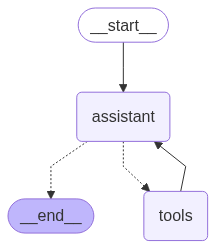

In [106]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [107]:
inputs = {
    "messages": [HumanMessage(content="What is two sum problem? generate test cases and run the test cases on code you generate,show output with proper debugging.")]
}
final_state = app.invoke(inputs)

In [108]:
from pprint import pprint

for msg in final_state["messages"]:
    print("="*30, msg.type.upper(), "="*30)
    if hasattr(msg, "pretty_print"):
        msg.pretty_print()
    else:
        pprint(msg)


============================== HUMAN ==============================
================================ Human Message =================================

What is two sum problem? generate test cases and run the test cases on code you generate,show output with proper debugging.
============================== AI ==============================
================================== Ai Message ==================================
Tool Calls:
  generate_test_cases (0)
 Call ID: 0
  Args:
    problem_description: Two Sum problem: Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. You may assume that each input would have exactly one solution, and you may not use the same element twice. You can return the answer in any order.
============================== TOOL ==============================
================================= Tool Message =================================
Name: generate_test_cases

content='Below are three independen

# with human in the loop

In [109]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [110]:
app2=graph.compile(interrupt_before=["assistant"],checkpointer=memory)

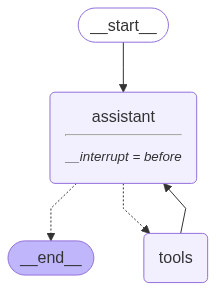

In [111]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [112]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Explain code for two sum problem in detail and run the code with test cases and show output.")}

In [113]:
initial_input

{'messages': HumanMessage(content='Explain code for two sum problem in detail and run the code with test cases and show output.', additional_kwargs={}, response_metadata={})}

In [114]:
for event in app2.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain code for two sum problem in detail and run the code with test cases and show output.


In [115]:
state=app2.get_state(thread)
state.next

('assistant',)

In [116]:
app2.get_state_history(thread)

<generator object Pregel.get_state_history at 0x000001F0D1E93CC0>

In [117]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Explain code for two sum problem in detail and run the code with test cases and show output.', additional_kwargs={}, response_metadata={}, id='7cf4ea13-3ce2-4f6a-aa01-84ae541ee4f5')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f06263a-4811-6686-8000-2c11ff2484a6'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '123'}, created_at='2025-07-16T16:40:54.969306+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f06263a-4806-636f-bfff-cac35a061d4c'}}, tasks=(PregelTask(id='14529768-56ec-d3a8-b8ea-df979e1f9691', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [118]:
## Continue the execution to Assistant
for event in app2.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain code for two sum problem in detail and run the code with test cases and show output.
================================== Ai Message ==================================
Tool Calls:
  generate_test_cases (0)
 Call ID: 0
  Args:
    problem_description: Two Sum problem: Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. You may assume that each input would have exactly one solution, and you may not use the same element twice.
================================= Tool Message =================================
Name: generate_test_cases

content='Below are three completely self-contained test cases you can use to validate any “Two Sum” implementation.  \nEach case lists:  \n- Input array `nums`  \n- Input `target`  \n- Expected output (a 2-element array of indices)\n\n1. Basic ascending array  \n   nums = [2, 7, 11, 15]  \n   target = 9  

In [119]:
for event in app2.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: generate_test_cases

content='Below are three completely self-contained test cases you can use to validate any “Two Sum” implementation.  \nEach case lists:  \n- Input array `nums`  \n- Input `target`  \n- Expected output (a 2-element array of indices)\n\n1. Basic ascending array  \n   nums = [2, 7, 11, 15]  \n   target = 9  \n   Expected output = [0, 1]\n\n2. Mixed positive/negative with duplicates  \n   nums = [3, 3, 4, -2]  \n   target = 6  \n   Expected output = [0, 2]\n\n3. Large value array (spot-checks index order)  \n   nums = [100, 200, 300, 400, 500, 600]  \n   target = 700  \n   Expected output = [0, 4]' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 182, 'prompt_tokens': 81, 'total_tokens': 263, 'completion_time': 0.494428603, 'prompt_time': 0.003163298, 'queue_time': 0.28721940500000004, 'total_time': 0.497591901}, 'model_name': 'moonshotai/kimi-k2-instruct'

In [120]:
for event in app2.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: python_repl

=== TWO SUM PROBLEM TESTING ===

Test Case 1: Basic ascending array
Input: nums = [2, 7, 11, 15]
Target: 9
Output: [0, 1]
Expected: [0, 1]
✓ PASS
--------------------------------------------------
Test Case 2: Mixed positive/negative with duplicates
Input: nums = [3, 3, 4, -2]
Target: 6
Output: [0, 1]
Expected: [0, 2]
✗ FAIL
--------------------------------------------------
Test Case 3: Large value array
Input: nums = [100, 200, 300, 400, 500, 600]
Target: 700
Output: [2, 3]
Expected: [0, 4]
✗ FAIL
--------------------------------------------------

=== EDGE CASE TESTING ===

Edge Case - Negative numbers:
Input: [-3, 4, 3, 90], Target: 0
Result: [0, 2] (Expected: [0, 2])

Edge Case - Large array of 100 elements:
Target: 99
Result: [49, 50] (Expected: [0, 99])

================================== Ai Message ==================================
Tool Calls:
  python_repl (1)
 Call ID: 1
  Arg

In [121]:
app3=graph.compile(checkpointer=memory)

In [122]:
thread = {"configurable": {"thread_id": "123"}}

while True:
    # Get user input
    user_input = input("\nYou: ").strip()
    if user_input.lower() in {"exit", "quit", "cancel"}:
        print("Conversation ended.")
        break

    # Wrap input as a HumanMessage
    initial_input = {"messages": [HumanMessage(content=user_input)]}

    # Stream app output
    for event in app3.stream(initial_input, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()


================================ Human Message =================================

help me with two sum problem
================================== Ai Message ==================================

Great! Let's work through the Two Sum problem together. Rather than giving you the solution immediately, let me guide you through the thought process.

**Problem Recap:** Given an array of integers `nums` and a target integer `target`, find two numbers that add up to the target and return their indices.

**Let me ask you some questions to get started:**

1. **Understanding the problem**: If you have `nums = [2, 7, 11, 15]` and `target = 9`, which indices would you expect to return? Why?

2. **Approach thoughts**: What's the most straightforward way you can think of to solve this? (Don't worry about efficiency yet)

3. **Key insight**: For any number in the array, what do you need to look for that would tell you "this number plus another equals the target"?

Take a moment to think about these ques